# Explore Bias

In this notebook the operators $T$ and $T^*$, and it's influence over the signals and noise are analysed. The original signal is attempted to be recovered simply with the pseudoinverse of $T^*T$ in the same way as the bias term and the initial guess are obtaied.

In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

from FBRN.proxop.hypercube import cardan
from FBRN.proxop.hyperslab import cardan_slab

## Create model

In [2]:
# Model parameters
params = {
    'N' : 2000,
    'k' : 50,
    'a' : 0.82,
    'r' : 1

}

In [3]:
model = FBRestNet(
    model_id = 'model_000_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    experimentation=Physics(params['N'],params['k'],params['a'],params['r']),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=10,
    val_size=2,
    batch_size=64,
    lr=3e-1, 
    nb_epochs=50,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=False,
    save_model=False,
    save_hist=True
    )

In [4]:
# Generate dataset
train_set, val_set = model.CreateDataSet()

## Prepare signal

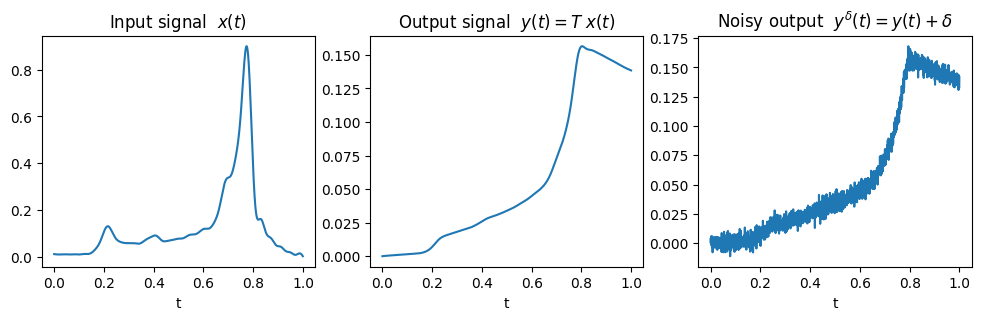

In [5]:
# Select one signal
signal_id = 1
[y,x] = val_set.dataset[signal_id:signal_id+1]
x_true = Variable(x, requires_grad=False)
x_bias = Variable(y, requires_grad=False)

# Input signal in the finite elements basis
test_signal_coeff = np.array(x_true[0,0])
test_signal_elt = torch.Tensor(model.physics.basis.T @ test_signal_coeff)

# Output signal with noise
y =  model.physics.Compute(test_signal_elt)
noise_std_dev = model.noise * np.sqrt((torch.sum(y**2)).item() )/np.sqrt(params['N'])
noise = torch.randn(test_signal_elt.shape) * noise_std_dev
y_noisy = model.physics.Compute(test_signal_elt) + noise

t = np.linspace(0,(params['N']-1)/params['N'],params['N'])
fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].plot(t, model.model.Layers[0].Pelt(x_true).numpy()[0,0])
ax[0].set_title(r'Input signal  $x(t)$')
ax[0].set_xlabel('t')
ax[1].plot(t, y)
ax[1].set_title(r'Output signal  $y(t)=T\;x(t)$')
ax[1].set_xlabel('t')
ax[2].plot(t, y_noisy)
ax[2].set_title(r'Noisy output  $y^{\delta}(t)=y(t) + \delta$')
ax[2].set_xlabel('t')
plt.show()

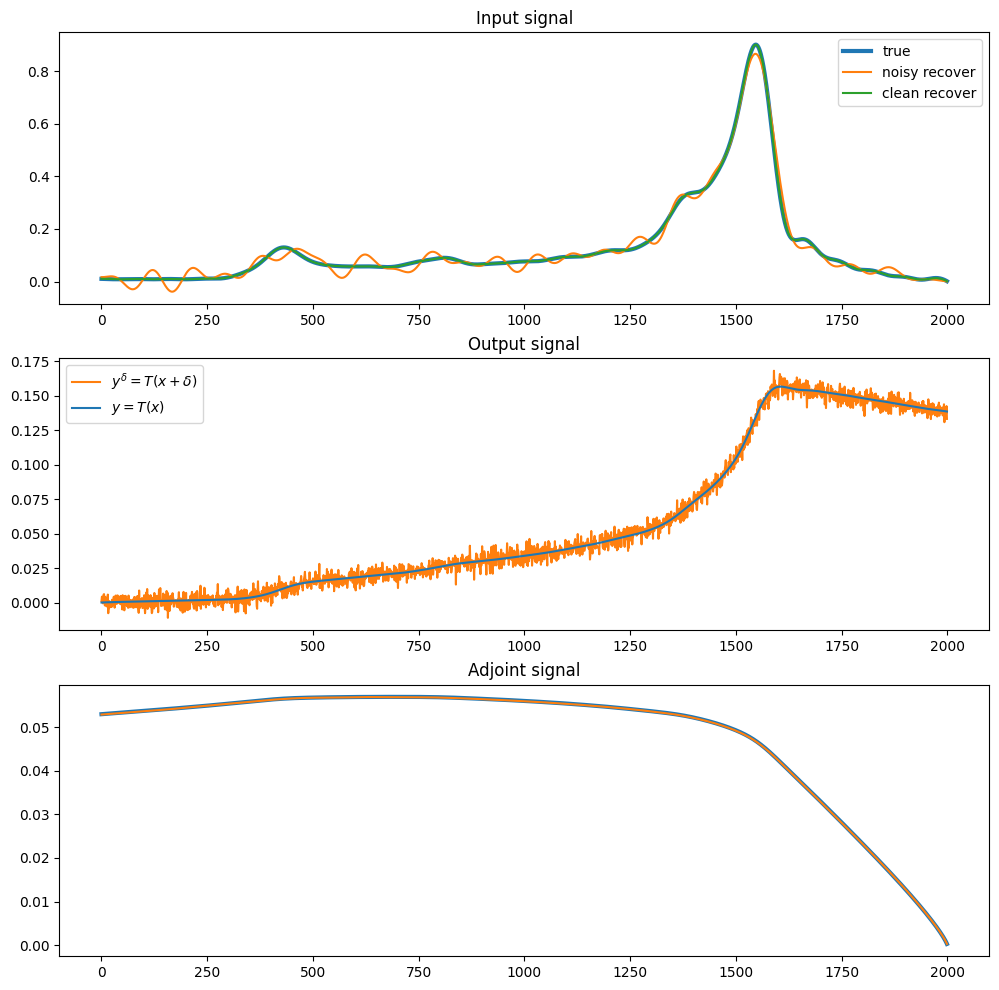

In [6]:

y_noisy_adj = model.physics.BasisChangeInv(model.physics.ComputeAdjoint(y_noisy))
y_adj = model.physics.BasisChangeInv(model.physics.ComputeAdjoint(y))

# T*T inverse
inv      = np.diag(model.physics.eigm**(2*model.physics.a))
tTTinv   = MyMatmul(inv)
x_hat_noisy   = tTTinv(torch.FloatTensor(np.array(model.physics.ComputeAdjoint(y_noisy))))
x_hat   = tTTinv(torch.FloatTensor(np.array(model.physics.ComputeAdjoint(y))))

im, ax = plt.subplots(3,1, figsize=(12,12))
ax[0].plot(test_signal_elt, label='true', linewidth=3)
ax[0].plot(model.physics.BasisChangeInv(x_hat_noisy), label='noisy recover')
ax[0].plot(model.physics.BasisChangeInv(x_hat), label='clean recover')
ax[0].legend()
ax[0].set_title('Input signal')

ax[1].plot(y_noisy, label='$y^{\delta}=T(x+\delta)$', color='C1')
ax[1].plot(y, label='$y=T(x)$', color='C0')
ax[1].legend()
ax[1].set_title('Output signal')

ax[2].plot(y_adj,linewidth=3)
ax[2].plot(y_noisy_adj)
ax[2].set_title('Adjoint signal')
plt.show()

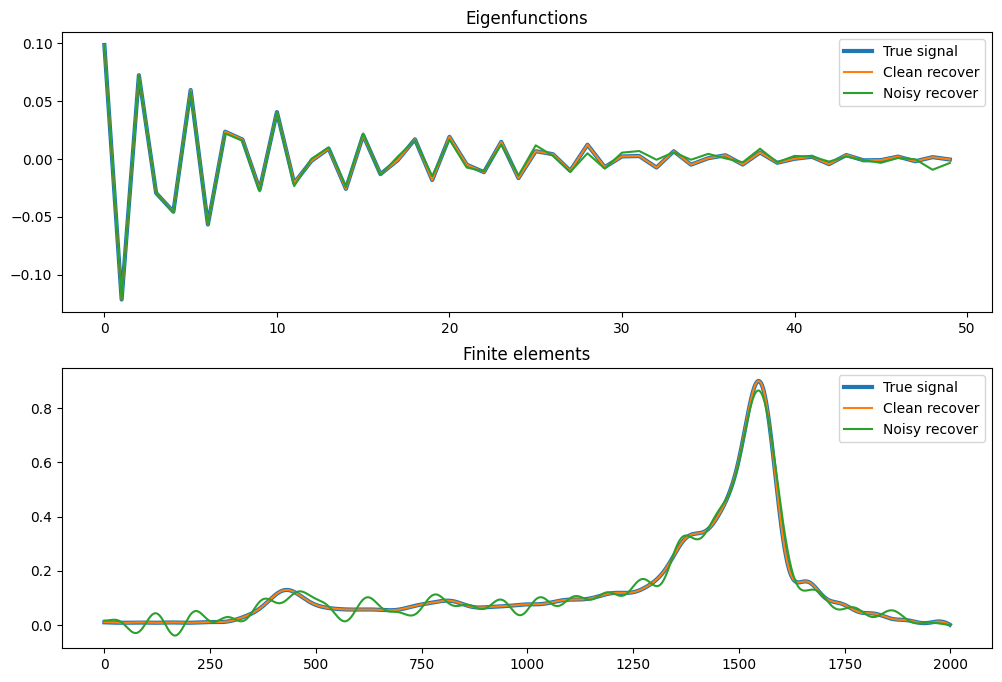

In [7]:
test_signal_eig = x_hat #model.physics.BasisChange(test_signal_elt)
test_signal_eig_noisy = x_hat_noisy
test_signal_elt_recover = model.physics.BasisChangeInv(test_signal_eig)
test_signal_elt_noisy_recover = model.physics.BasisChangeInv(test_signal_eig_noisy)

fig,ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(test_signal_coeff, label='True signal', linewidth=3)
ax[0].plot(test_signal_eig, label='Clean recover')
ax[0].plot(test_signal_eig_noisy, label='Noisy recover')
ax[0].set_title('Eigenfunctions')
ax[0].legend()

ax[1].plot(test_signal_elt, label='True signal', linewidth=3)
ax[1].plot(test_signal_elt_recover, label='Clean recover')
ax[1].plot(test_signal_elt_noisy_recover, label='Noisy recover')
ax[1].set_title('Finite elements')
ax[1].legend()
plt.show()

# T operator in finite elements space

In [23]:
from scipy.special import gamma

In [11]:
x_true_elt = model.model.Layers[0].Pelt(x_true).numpy()[0,0]
y_true_elt = y

In [12]:
# T operator as defined in the paper
a = params['a']
h = 1/(params['N']) # correction to the paper, where h=1/(N-1).

g = gamma(a)

Ta = np.zeros((params['N'],params['N']))

for i in range(params['N']):
    for j in range(params['N']):
        if j<i:
            Ta[i,j]=h**a/(2*g*a) * ((i-j+1)**a-(i-j-1)**a)
        if j==0 and i!=0:
            Ta[i,j]=h**a/(2*g*a) * ((i)**a - (i-1)**a)
        if j==i and i!=0:
            Ta[i,j]=h**a/(2*g*a)
        if i==j and i==0:
            Ta[i,j]=0
        if j>i:
            Ta[i,j]=0

Tadj = np.zeros((params['N'],params['N']))

for i in range(params['N']):
    for j in range(params['N']):
        if j>i and j!=(params['N']-1):
            Tadj[i,j]=h**(a)/(2*g*(a)) * ((j-i+1)**(a)-(j-i-1)**(a))
        if j==(params['N']-1) and i!=j:
            Tadj[i,j]=h**(a)/(2*g*(a)) * (2* (j-i+1)**(a) - (j-i)**(a) - (j-i-1)**a)
        if j==i and i!=(params['N']-1):
            Tadj[i,j]=h**(a)/(2*g*(a))
        if i==j and i==(params['N']-1):
            Tadj[i,j]=h**(a)/(g*(a))
        if j<i:
            Tadj[i,j]=0

[]

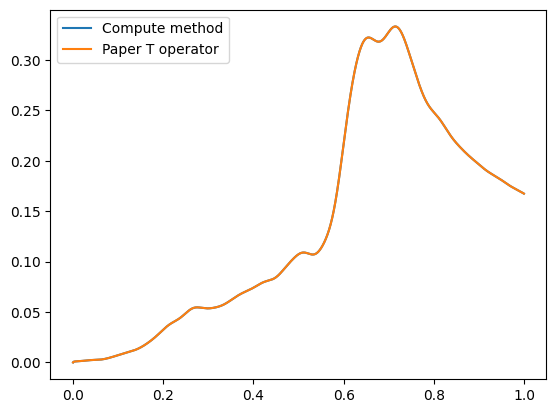

In [13]:
plt.plot(t, y, label='Compute method')
plt.plot(t, Ta.dot(x_true_elt), label='Paper T operator')
plt.legend()
plt.plot()

In [14]:
T_1 = np.zeros((params['N'],params['N']))
a_1 = 1
g_1 = gamma(1)
for i in range(params['N']):
    for j in range(params['N']):
        if j<i:
            T_1[i,j]=h**a_1/(2*g_1*a_1) * ((i-j+1)**a_1-(i-j-1)**a_1)
        if j==0 and i!=0:
            T_1[i,j]=h**a_1/(2*g_1*a_1) * ((i)**a_1 - (i-1)**a_1)
        if j==i and i!=0:
            T_1[i,j]=h**a_1/(2*g_1*a_1)
        if i==j and i==0:
            T_1[i,j]=0
        if j>i:
            T_1[i,j]=0

Tadj_1 = np.zeros((params['N'],params['N']))

for i in range(params['N']):
    for j in range(params['N']):
        if j>i and j!=(params['N']-1):
            Tadj_1[i,j]=h**(a_1)/(2*g_1*(a_1)) * ((j-i+1)**(a_1)-(j-i-1)**(a_1))
        if j==(params['N']-1) and i!=j:
            Tadj_1[i,j]=h**(a_1)/(2*g_1*(a_1)) * (2* (j-i+1)**(a_1) - (j-i)**(a_1) - (j-i-1)**a_1)
        if j==i and i!=(params['N']-1):
            Tadj_1[i,j]=h**(a_1)/(2*g_1*(a_1))
        if i==j and i==(params['N']-1):
            Tadj_1[i,j]=h**(a_1)/(g_1*(a_1))
        if j<i:
            Tadj_1[i,j]=0

T_1_2 = np.zeros((params['N'],params['N']))
g_1_2 = gamma(0.5)
a_1_2 = 0.5
for i in range(params['N']):
    for j in range(params['N']):
        if j<i:
            T_1_2[i,j]=h**a_1_2/(2*g_1_2*a_1_2) * ((i-j+1)**a_1_2-(i-j-1)**a_1_2)
        if j==0 and i!=0:
            T_1_2[i,j]=h**a_1_2/(2*g_1_2*a_1_2) * ((i)**a_1_2 - (i-1)**a_1_2)
        if j==i and i!=0:
            T_1_2[i,j]=h**a_1_2/(2*g_1_2*a_1_2)
        if i==j and i==0:
            T_1_2[i,j]=0
        if j>i:
            T_1_2[i,j]=0

Tadj_1_2 = np.zeros((params['N'],params['N']))

for i in range(params['N']):
    for j in range(params['N']):
        if j>i and j!=(params['N']-1):
            Tadj_1_2[i,j]=h**(a_1_2)/(2*g_1_2*(a_1_2)) * ((j-i+1)**(a_1_2)-(j-i-1)**(a_1_2))
        if j==(params['N']-1) and i!=j:
            Tadj_1_2[i,j]=h**(a_1_2)/(2*g_1_2*(a_1_2)) * (2* (j-i+1)**(a_1_2) - (j-i)**(a_1_2) - (j-i-1)**a_1_2)
        if j==i and i!=(params['N']-1):
            Tadj_1_2[i,j]=h**(a_1_2)/(2*g_1_2*(a_1_2))
        if i==j and i==(params['N']-1):
            Tadj_1_2[i,j]=h**(a_1_2)/(g_1_2*(a_1_2))
        if j<i:
            Tadj_1_2[i,j]=0

[]

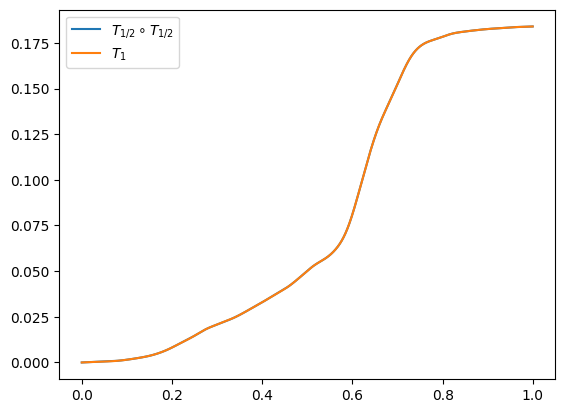

In [15]:
plt.plot(t, T_1_2.dot(T_1_2.dot(x_true_elt)), label=r'$T_{1/2} \circ T_{1/2}$')
plt.plot(t, T_1.dot(x_true_elt), label=r'$T_{1}$')
plt.legend()
plt.plot()

[]

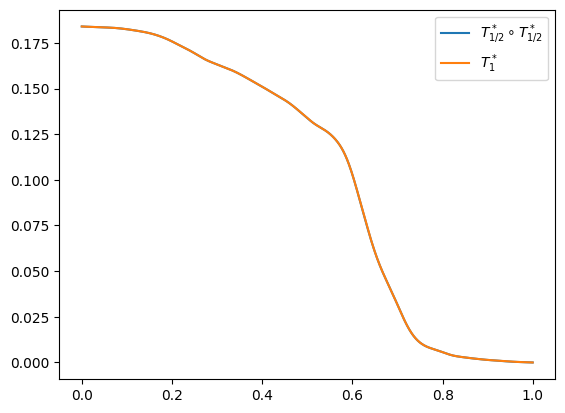

In [16]:
plt.plot(t, Tadj_1_2.dot(Tadj_1_2.dot(x_true_elt)), label=r'$T^*_{1/2} \circ T^*_{1/2}$')
plt.plot(t, Tadj_1.dot(x_true_elt), label=r'$T^*_{1}$')
plt.legend()
plt.plot()

In [17]:
print(np.around(Tadj[-10:,-10:]*1e2, 2))
print()
print(np.around(Ta[:10,:10]*1e2, 2))

[[1.26 1.78 0.92 0.74 0.64 0.57 0.52 0.48 0.45 0.63]
 [0.   1.26 1.78 0.92 0.74 0.64 0.57 0.52 0.48 0.66]
 [0.   0.   1.26 1.78 0.92 0.74 0.64 0.57 0.52 0.71]
 [0.   0.   0.   1.26 1.78 0.92 0.74 0.64 0.57 0.76]
 [0.   0.   0.   0.   1.26 1.78 0.92 0.74 0.64 0.84]
 [0.   0.   0.   0.   0.   1.26 1.78 0.92 0.74 0.93]
 [0.   0.   0.   0.   0.   0.   1.26 1.78 0.92 1.08]
 [0.   0.   0.   0.   0.   0.   0.   1.26 1.78 1.32]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.26 2.31]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   2.52]]

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.26 1.26 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.52 1.78 1.26 0.   0.   0.   0.   0.   0.   0.  ]
 [0.4  0.92 1.78 1.26 0.   0.   0.   0.   0.   0.  ]
 [0.34 0.74 0.92 1.78 1.26 0.   0.   0.   0.   0.  ]
 [0.3  0.64 0.74 0.92 1.78 1.26 0.   0.   0.   0.  ]
 [0.27 0.57 0.64 0.74 0.92 1.78 1.26 0.   0.   0.  ]
 [0.25 0.52 0.57 0.64 0.74 0.92 1.78 1.26 0.   0.  ]
 [0.23 0.48 0.52 0.57 0.64 0.74 0.92 1.78 1.

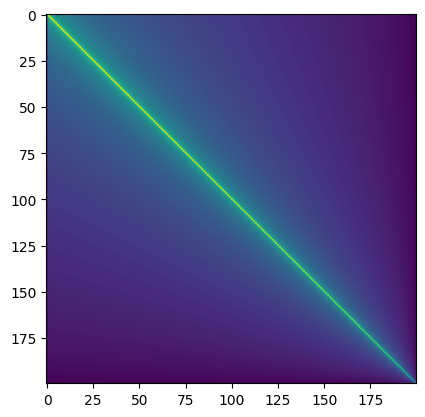

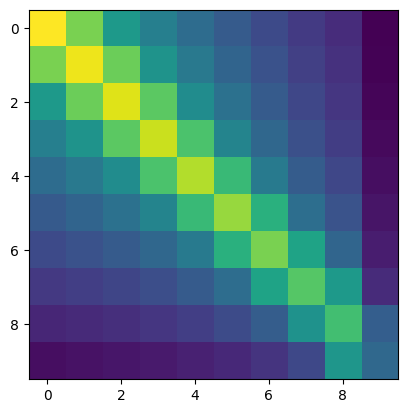

In [18]:
plt.imshow((Tadj.dot(Ta))[::10,::10])
plt.show()
plt.imshow((Tadj.dot(Ta))[-10:,-10:])
plt.show()

[]

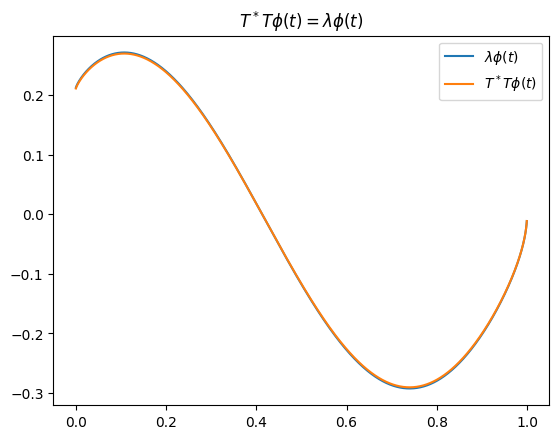

In [19]:
idx = 1
eig_func = model.physics.basis[idx,:]
eig_val  = (1/model.physics.eigm**(2*a))[idx]
plt.plot(t,eig_func*eig_val, label=r'$\lambda \phi(t)$')
plt.plot(t,Tadj.dot(Ta).dot(eig_func), label=r'$T^*T\phi(t)$')
plt.title(r'$T^*T\phi(t)=\lambda \phi(t)$')
plt.legend()
plt.plot()


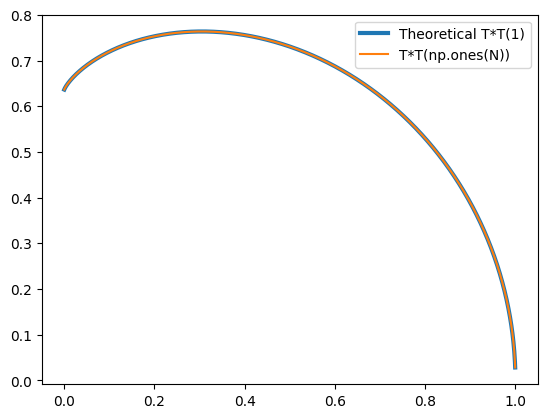

In [20]:
TT = Tadj.dot(Ta)
s = np.linspace(0,params['N']-1,params['N'])/params['N']
y_adj_1_2 = 2/gamma(1/2)**2 * (np.sqrt(1-s) + s * np.log(1+np.sqrt(1-s)) - s*np.log(np.sqrt(s)+1e-32))
plt.plot(s, y_adj_1_2,linewidth=3, label='Theoretical T*T(1)')
plt.plot(s,TT.dot(np.ones((2000,1))), label='T*T(np.ones(N))')
plt.legend()
plt.show()

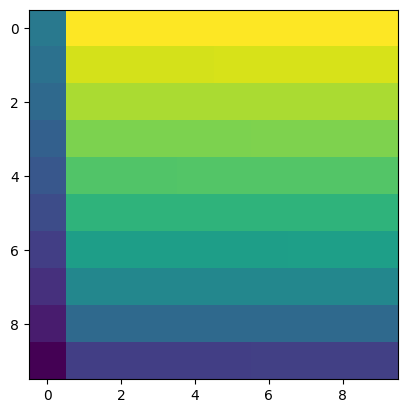

[]

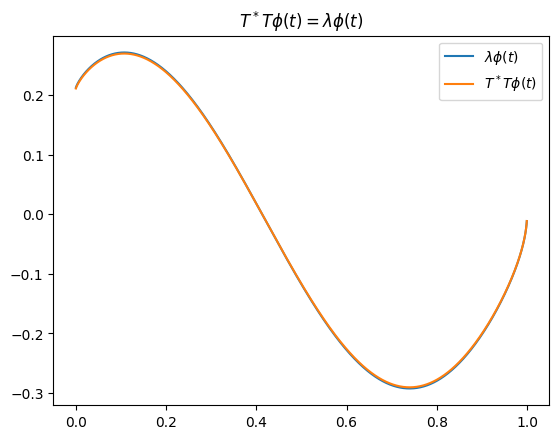

In [21]:
plt.imshow(TT[-10:,:10])
plt.show()

plt.plot(t,eig_func*eig_val, label=r'$\lambda \phi(t)$')
plt.plot(t,TT.dot(eig_func), label=r'$T^*T\phi(t)$')
plt.title(r'$T^*T\phi(t)=\lambda \phi(t)$')
plt.legend()
plt.plot()

In [22]:
import numpy.linalg as la

In [27]:
physics_1 = Physics(2000,50,1,1)
TT_1 = Tadj_1.dot(T_1)
TT_1.shape

(2000, 2000)

In [24]:
w, v = la.eig(TT_1)
w_1_2, v_1_2 = la.eig(TT)

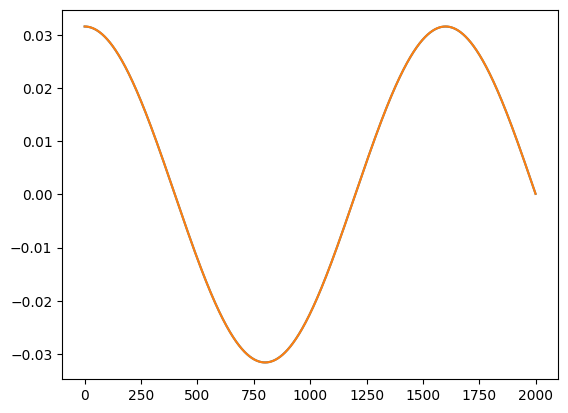

In [28]:
idx = 2
plt.plot(np.sign(v[0,idx])*v[:,idx], label='eigenfunction')
plt.plot(physics_1.basis[idx]/np.sqrt(2000))

In [29]:
idx = 10
model.physics.inner_prod(v[:,idx]*np.sqrt(2000),v[:,10]*np.sqrt(2000))

0.9995002498580815

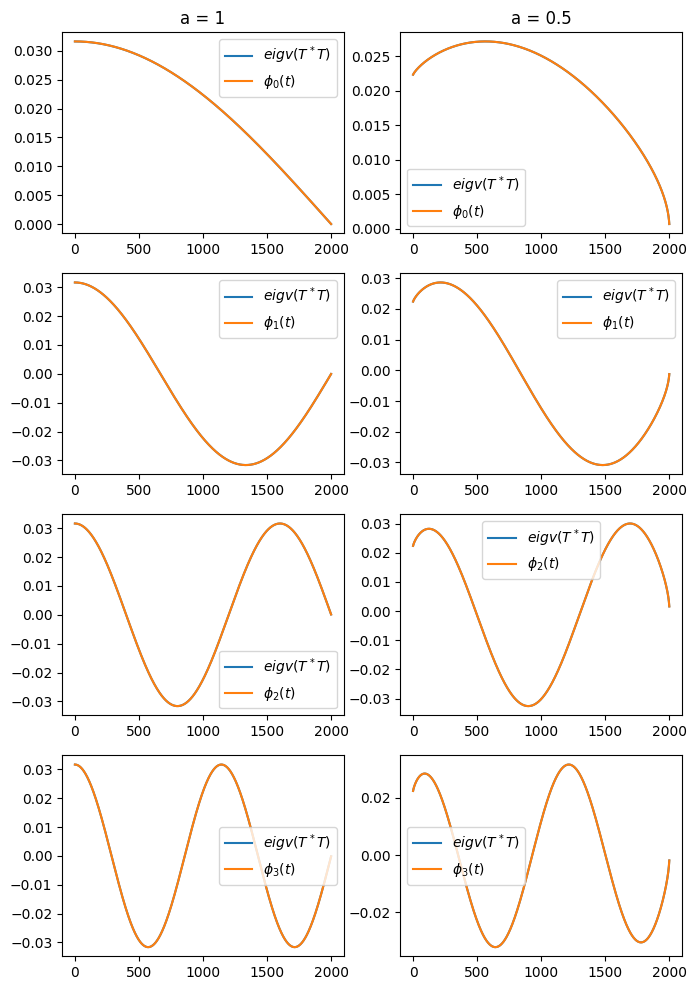

In [31]:
im, ax = plt.subplots(4,2,figsize=(8,12))

ax[0,0].set_title('a = 1')
ax[0,1].set_title('a = 0.5')

for i in range(4):
    ax[i,0].plot(np.sign(v[0,i])*v[:,i], label=r'$eigv(T^*T)$')
    ax[i,0].plot(physics_1.basis[i]/np.sqrt(2000), label=r'$\phi_{}(t)$'.format(i))
    ax[i,0].legend()

    ax[i,1].plot(np.sign(v_1_2[0,i])*v_1_2[:,i], label=r'$eigv(T^*T)$')
    ax[i,1].plot(model.physics.basis[i]/np.sqrt(2000), label=r'$\phi_{}(t)$'.format(i))
    ax[i,1].legend()

# plt.savefig('eigenvectors_vs_basis.png')

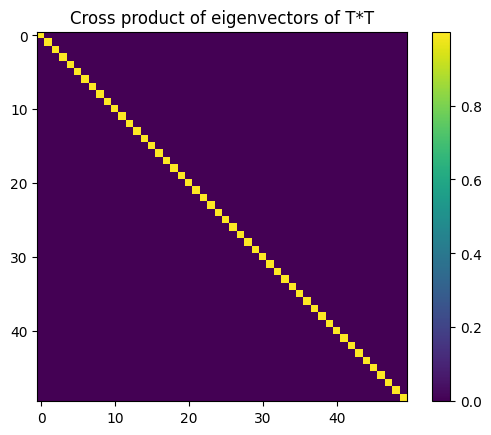

In [29]:
cross_prod =  np.zeros((params['k'],params['k']))

for i in range(params['k']):
    for j in range(params['k']):
        cross_prod[i,j] = model.physics.inner_prod(v_1_2[:,i]*np.sqrt(2000),v_1_2[:,j]*np.sqrt(2000) )

plt.imshow(cross_prod)
plt.title('Cross product of eigenvectors of T*T')
plt.colorbar()
plt.show()

In [35]:
np.diag(np.sign(model.physics.basis[:,0])).dot(model.physics.basis)

array([[ 0.99999421,  1.00200571,  1.00362904, ...,  0.05303532,
         0.04326036,  0.03057218],
       [ 0.99997135,  1.00584341,  1.01046163, ..., -0.09616561,
        -0.07830067, -0.05527727],
       [ 0.99994122,  1.00890976,  1.01581164, ...,  0.12422356,
         0.10101089,  0.07125339],
       ...,
       [ 0.9963926 ,  1.09781705,  1.15844643, ..., -0.61583886,
        -0.48864114, -0.33916935],
       [ 0.99629478,  1.09929628,  1.16057241, ...,  0.62336053,
         0.49453353,  0.34320839],
       [ 0.99619663,  1.10081017,  1.16276766, ..., -0.63087923,
        -0.50041428, -0.34723506]])